In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from qkeras.utils import _add_supported_quantized_objects
import tensorflow as tf
import hls4ml
import keras
import argparse
import yaml
import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
def yaml_load(config):
    with open(config, 'r') as stream:
        param = yaml.safe_load(stream)
    return param

def print_dict(d, indent=0):
    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))
def post_process(model, output_dir):
    
    isExist = os.path.exists(OUTPUT_DIR)
    if not isExist:
        os.makedirs(OUTPUT_DIR)

    img = np.load('02_scan_x256_y256_raw.npy')
    img = np.transpose(img,(2,3,0,1))
    data_r = np.copy(img)
    data_r[data_r>1e3]=1e3
    min_ = np.min(data_r)
    max_ = np.max(data_r)

    data_r = 1.0*(data_r-min_)/(max_-min_)

    data_r = data_r.reshape(-1,1,124,124)
    data_r_cut = data_r[:,:,2:122,2:122]
    data_r_cut = data_r_cut.reshape(256,256,120,120)
    X = data_r_cut.reshape(-1, 120,120)

    # generate outputs/targets
    dataset_h5 = h5py.File('unbinned_results.h5','r+')
    rots = np.array(dataset_h5['rotation'])
    scal = np.array(dataset_h5['scale'])
    y = np.concatenate((rots, scal), axis=1)
    sc = StandardScaler()
    _ = sc.fit(y)
    base_8 = np.load('base_8.npy', allow_pickle=1)


    predictions = model.predict(np.ascontiguousarray(X))
    predictions = sc.inverse_transform(predictions)

    rotation_, scale_ = predictions[:, 0:2], predictions[:, 2:]

    mse = np.mean((predictions - y)**2)
    print('model MSE on full dataset: ', mse)

    #base=2,loss=0.024
    j=0
    list_new = []
    fig,ax = plt.subplots(1,3,figsize=(20,10))
    for i in range(2):
        if np.sum(base_8[:,i]!=0):
            j+=1
            print(i)
            list_new.append(i)
            ax[i].title.set_text(str(i))
            ax[i].imshow(base_8[:,i].reshape(256,256))
    print('total activated channels: '+str(j))
    ax[2].title.set_text('mean of the sample domain')
    ax[2].imshow(np.mean(data_r_cut.reshape(256,256,-1),axis=2))

    fig,ax = plt.subplots(2,2,figsize = (10,10))
    ax[0][0].imshow(rotation_[:,0].reshape(256,256))
    ax[0][1].imshow(rotation_[:,1].reshape(256,256))
    ax[1][0].hist(rotation_[:,0].reshape(-1),200)
    ax[1][1].hist(rotation_[:,1].reshape(-1),200)
    fig.savefig('{output_dir}/rotation.png'.format(output_dir=output_dir))

    sample_base = base_8[:,1].reshape(256,256)

    scale_0 = np.multiply(sample_base.reshape(256,256),scale_[:,0].reshape(256,256))
    scale_1 = np.multiply(sample_base.reshape(256,256),scale_[:,3].reshape(256,256))

    fig,ax = plt.subplots(2,2,figsize = (10,10))
    clim0 = [1.14,1.19]
    clim1 = [1.1,1.17]
    ax[0][0].imshow(scale_0,clim=clim0)
    ax[0][1].imshow(scale_1,clim=clim1)
    ax[1][0].hist(scale_0.reshape(-1),200,range=clim0)
    ax[1][1].hist(scale_1.reshape(-1),200,range=clim1)
    fig.savefig('{output_dir}/scale.png'.format(output_dir=output_dir))


    right_tri = np.sqrt(scale_0**2+scale_1**2).reshape(256,256)
    np.save('right_triangle_mlp_average_pool.npy', right_tri)
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    clim=[1.59,1.65]
    ax[0].imshow(right_tri,clim=clim)
    ax[1].hist(right_tri.reshape(-1),200,range=clim)
    fig.savefig('{output_dir}/right_triangle.png'.format(output_dir=output_dir))

In [3]:
# load keras model
OUTPUT_DIR = 'convert/models/mlp_max_pool_12b'
HLS_OUTPUT_DIR = 'convert/models/mlp_max_pool_12b/hls'
REUSE_FACTOR = 64
co = {}
_add_supported_quantized_objects(co)
MODEL = keras.models.load_model('models/mlp_max_pool_12b/model.h5', custom_objects=co)
MODEL.summary()

2022-05-31 23:52:45.785937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 23:52:47.475892: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 23:52:47.476637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-31 23:52:47.478046: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 1)]     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 1)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 q_dense (QDense)            (None, 64)                57664     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 q_activation (QActivation)  (None, 64)                0     

2022-05-31 23:54:55.501507: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400


model MSE on full dataset:  0.012666225958939547
0
1
total activated channels: 2


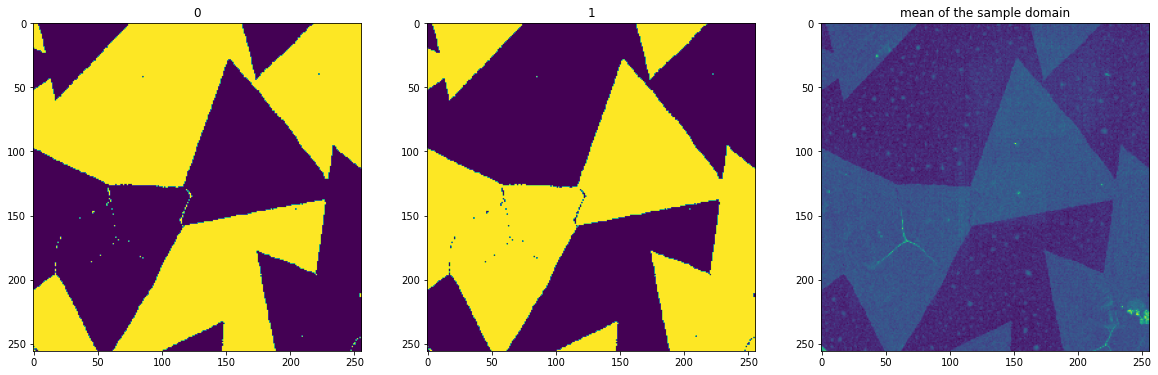

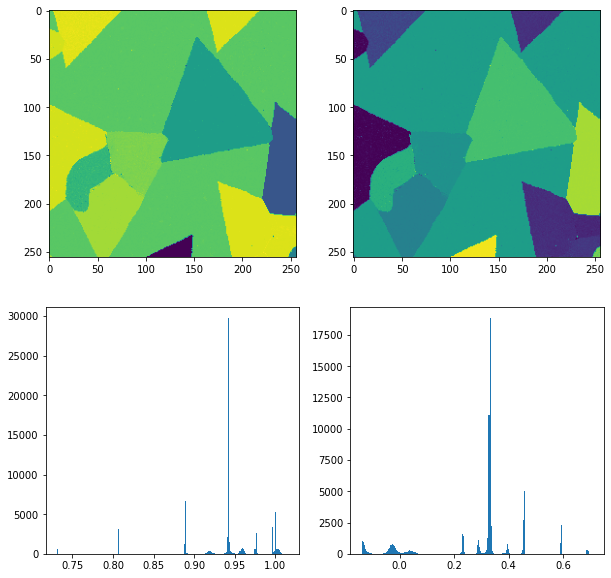

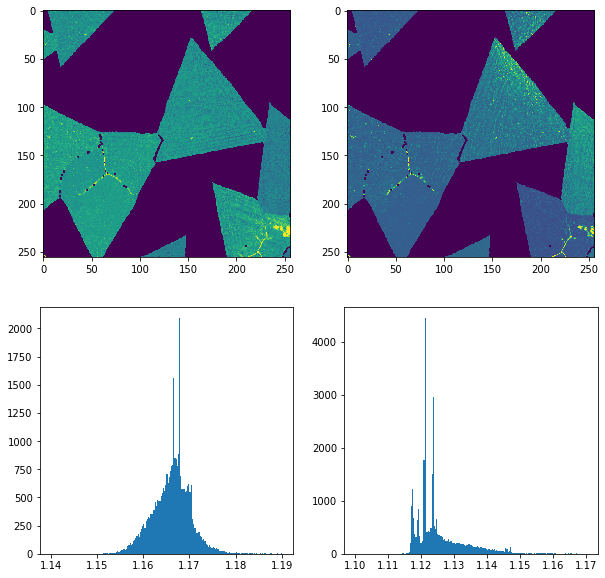

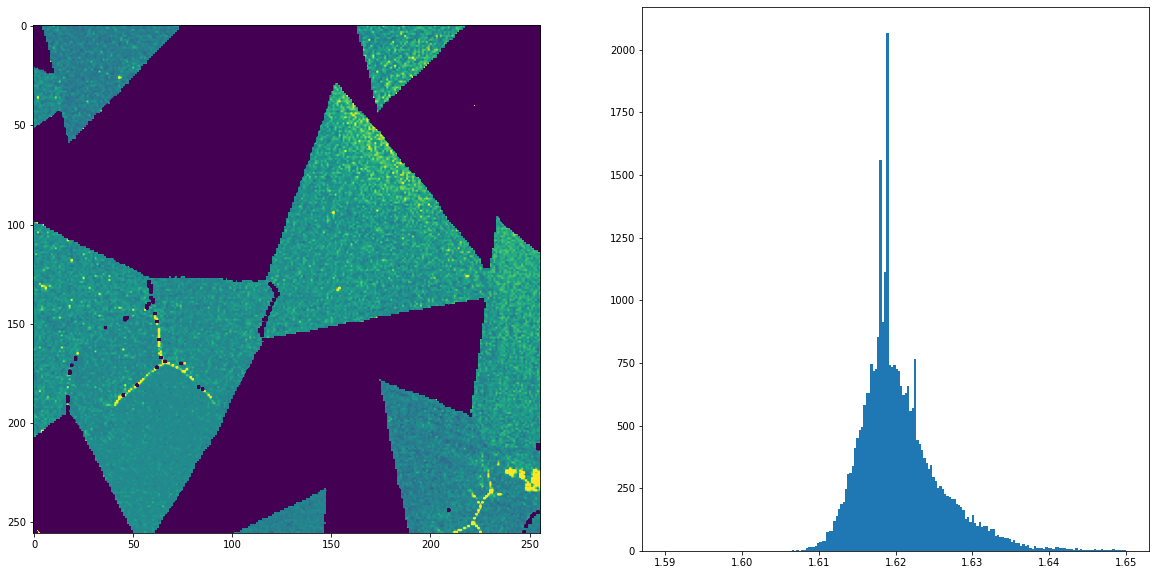

In [4]:
%matplotlib inline
post_process(MODEL, OUTPUT_DIR)

## Convert Model 

In [6]:
os.environ['PATH'] = "/tools/Xilinx/Vivado/2019.1/bin:" + os.environ['PATH']

# config = hls4ml.utils.config_from_keras_model(MODEL, granularity='name')
param = yaml_load('convert_configs/mlp_max_pool_12b/mlp_max_pool_12b.yml')
config = param['HLSConfig']
config['Model']['ReuseFactor'] = REUSE_FACTOR
config['SkipOptimizers']= ['relu_merge']
config['Model']['Strategy'] = 'Resource'
config['LayerName']['input_1']['Precision'] = 'ap_fixed<32,16>'
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True
    config['LayerName'][layer]['ReuseFactor'] = REUSE_FACTOR

In [7]:
hls_model = hls4ml.converters.convert_from_keras_model(MODEL,
                                                        hls_config=config,
                                                        output_dir=HLS_OUTPUT_DIR,
                                                        part='xcu250-figd2104-2L-e',
                                                        io_type='io_stream')
hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 120, 120, 1]], output shape: [None, 120, 120, 1]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 120, 120, 1]], output shape: [None, 30, 30, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 30, 30, 1]], output shape: [None, 900]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 900]], output shape: [None, 64]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32]], output shape: [Non

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 120, 120, 1]], output shape: [None, 120, 120, 1]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 120, 120, 1]], output shape: [None, 30, 30, 1]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 30, 30, 1]], output shape: [None, 900]
Layer name: q_dense, layer type: QDense, input shapes: [[None, 900]], output shape: [None, 64]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: q_dense_1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 32]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: q_activation_1, layer type: Activation, input shapes: [[None, 32]], output shape: [Non

(<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>)

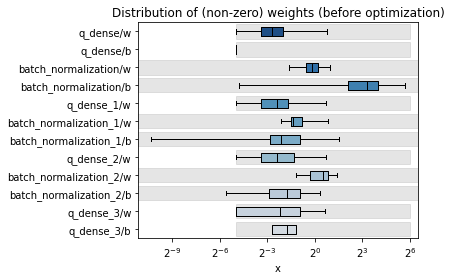

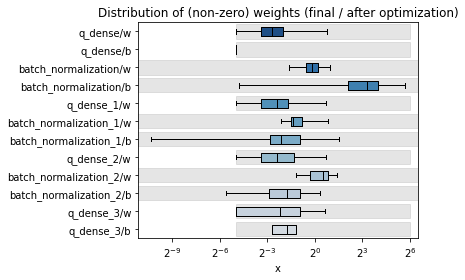

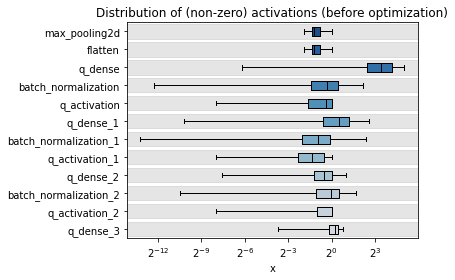

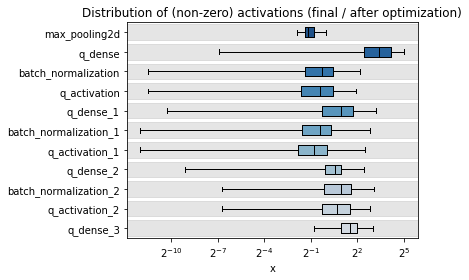

In [8]:
img = np.load('02_scan_x256_y256_raw.npy')
img = np.transpose(img,(2,3,0,1))
data_r = np.copy(img)
data_r[data_r>1e3]=1e3
min_ = np.min(data_r)
max_ = np.max(data_r)

data_r = 1.0*(data_r-min_)/(max_-min_)

data_r = data_r.reshape(-1,1,124,124)
data_r_cut = data_r[:,:,2:122,2:122]
data_r_cut = data_r_cut.reshape(256,256,120,120)
X = data_r_cut.reshape(-1, 120,120)

%matplotlib inline
hls4ml.model.profiling.numerical(model=MODEL, hls_model = hls_model, X=X[0:100])

In [ ]:

# Run tracing on a portion of the test set for the hls model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X[0]))

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(MODEL, X[0][0])

In [ ]:
%matplotlib inline
for key in hls4ml_trace:
    plt.figure()
    plt.scatter(keras_trace[key][0], hls4ml_trace[key][0], color='black')
    plt.plot(np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), 
             np.linspace(np.min(keras_trace[key][0]),np.max(keras_trace[key][0]), 10), label='keras_range')
    plt.plot(np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), 
             np.linspace(np.min(hls4ml_trace[key][0]),np.max(hls4ml_trace[key][0]), 10), label='hls4ml_range')
    plt.title(key)
    plt.xlabel('keras output')
    plt.ylabel('hls4ml output')
    plt.legend()
    plt.show()

In [ ]:
# %matplotlib inline
# tf.keras.utils.plot_model(
#     MODEL,
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=False,
# )

In [ ]:
# %matplotlib inline
# hls4ml.utils.plot_model(
#     hls_model, show_shapes=True, show_precision=True,
# )